# Image classifier

Built a convolutional neural network that classifies cars into sedans and suvs(light) and trucks (heavy). This serves to automate and improve the speed of toll collections.

Imported the neccesary libraries

In [1]:
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import itertools
import base64
import io

Defined the arguments for the neural network

In [2]:
breeds=['Sedan', 'SUV', 'Truck']

args = {
    'labels': 'inferred',
    'label_mode': 'categorical',
    'batch_size': 32,
    'image_size': (256, 256),
    'seed': 1,
    'validation_split': 0.2,
    'class_names': breeds
}

Loaded the train and test datasets. Used 80% for training and 20% for testing 

In [3]:
train = tf.keras.utils.image_dataset_from_directory(
    "images3",
    subset="training",
    **args
)

test = tf.keras.utils.image_dataset_from_directory(
  "images3",
  subset="validation",
    **args
)

Found 6172 files belonging to 3 classes.
Using 4938 files for training.
Found 6172 files belonging to 3 classes.
Using 1234 files for validation.


Looked for an image of the train dataset

2023-04-09 21:31:44.280946: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


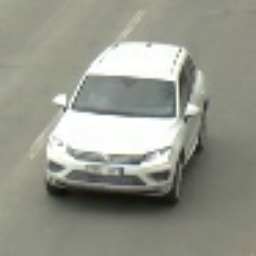

In [4]:
first = train.take(1)
images, labels = list(first)[0]
Image.fromarray(images[7].numpy().astype("uint8"))

Prefetched the train and test dataset to improve performance

In [5]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Created a function that creates the neural network, compiles the model, fits the model and creates a history dataframe that contains the results of the model

In [6]:
def train_model(network, epochs=5):
    model = Sequential(network)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(
      train,
      validation_data=test,
      epochs=epochs
    )
    history_df = pd.DataFrame.from_dict(history.history)
    return history_df, model

Created a list with the layers to use in the neural network. Then passed this list as a parameter to the function created.

In [7]:
network = [
  layers.RandomFlip('horizontal', seed=1),
  layers.RandomRotation(0.2, seed=1),
  layers.RandomZoom(0.2, seed=1),
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 4, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(breeds))
]

history_df, model = train_model(network,20)

Epoch 1/20
155/155 [==============================] - 100s 641ms/step - loss: 0.9722 - accuracy: 0.5474 - val_loss: 0.6821 - val_accuracy: 0.6686
Epoch 2/20
155/155 [==============================] - 114s 734ms/step - loss: 0.7327 - accuracy: 0.6432 - val_loss: 0.6048 - val_accuracy: 0.7188
Epoch 3/20
155/155 [==============================] - 111s 718ms/step - loss: 0.5736 - accuracy: 0.7276 - val_loss: 0.4855 - val_accuracy: 0.7674
Epoch 4/20
155/155 [==============================] - 110s 712ms/step - loss: 0.5248 - accuracy: 0.7537 - val_loss: 0.5142 - val_accuracy: 0.7650
Epoch 5/20
155/155 [==============================] - 112s 723ms/step - loss: 0.4908 - accuracy: 0.7724 - val_loss: 0.4649 - val_accuracy: 0.7925
Epoch 6/20
155/155 [==============================] - 116s 749ms/step - loss: 0.4741 - accuracy: 0.7793 - val_loss: 0.3818 - val_accuracy: 0.8355
Epoch 7/20
155/155 [==============================] - 119s 770ms/step - loss: 0.4281 - accuracy: 0.8104 - val_loss: 0.5482 -

In the plot, we can see how the accuracy improves when the epochs increase.

<AxesSubplot:>

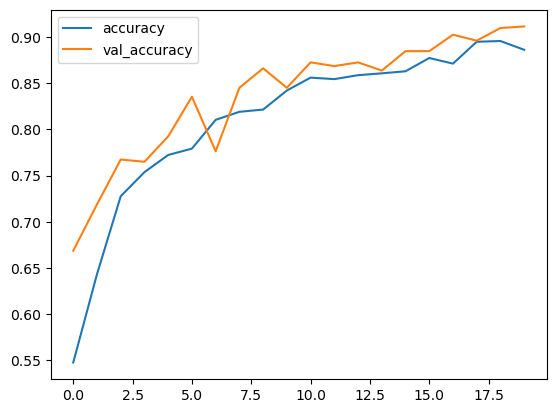

In [8]:
history_df[['accuracy', 'val_accuracy']].plot()

Made the predictions and showed 5 examples of dogs from the test set and how they were predicted.

39/39 [==============================] - 7s 183ms/step


,prediction,actual,image
0,Sedan,SUV,
1,SUV,SUV,
2,Truck,Truck,
3,Sedan,Sedan,
4,Sedan,Sedan,

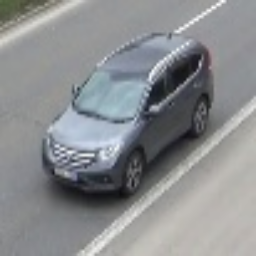
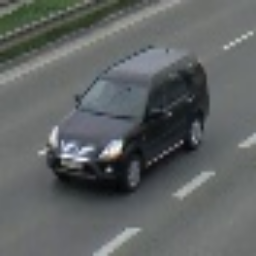
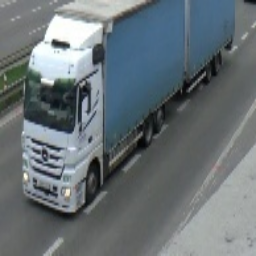
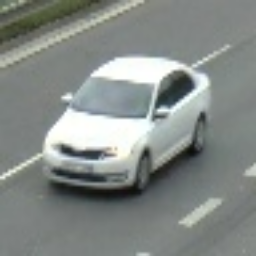
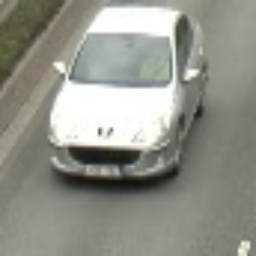

In [9]:
preds = model.predict(test)
predicted_class = np.argmax(preds, axis=1)
actual_labels = np.concatenate([y for x, y in test], axis=0)

actual_image = [x.numpy().astype('uint8') for x, y in test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

actual_class = np.argmax(actual_labels, axis=1)

pred_df = pd.DataFrame(zip(predicted_class, actual_class, actual_image), columns=['prediction', 'actual', 'image'])
pred_df['prediction'] = pred_df['prediction'].apply(lambda x: breeds[x])
pred_df['actual'] = pred_df['actual'].apply(lambda x: breeds[x])

def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_str}">'

pred_df.head().style.format({'image': image_formatter})

The accuracy score for the neural network is 91%.

In [10]:
from sklearn.metrics import accuracy_score
print(round(accuracy_score(actual_class, predicted_class),2))

0.91
